In [73]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import geopandas as gpd
import math
import time
import random
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from scipy.spatial import Delaunay
from sklearn.metrics.pairwise import cosine_similarity



Load data

In [74]:
final_dataframes = pd.read_pickle('/Users/niklasandersen/Documents/GitHub/P5/data_prep/one_year.pkl')
four_days = pd.read_pickle('/Users/niklasandersen/Documents/Github/P5/data_prep/four_days_data.pkl')

### Lookback and prediction horizon

In [78]:
# Define the train ratio
train_ratio = 0.7  # 80% training data
lookback = 50
pred_horizon = 5
#df_dict = final_dataframes


def split_data(data, train_ratio=0.7):
    df_dict_train = {}
    df_dict_test = {}
    for key, df in data.items():
        n_time_steps = len(df['traffic_flow'])
        train_size = int(n_time_steps * train_ratio)
        df_train = df.iloc[:train_size].copy()
        df_test = df.iloc[train_size:].copy()
        df_dict_train[key] = df_train
        df_dict_test[key] = df_test
    return train_size, df_train, df_test, df_dict_train, df_dict_test

train_size, df_train, df_test, df_dict_train, df_dict_test = split_data(final_dataframes, train_ratio=0.7)
train_size4, df_train4, df_test4, df_dict_train4, df_dict_test4 = split_data(four_days, train_ratio=0.7)

In [79]:
print(train_size, train_size4)

24114 268


In [80]:
def create_sliding_window_data(df_dict, lookback, pred_horizon):
    X_dict = {}
    y_dict = {}
    for key, df in df_dict.items():
        node_series = df['traffic_flow'].values
        X_node = []
        y_node = []
        for i in range(len(node_series) - lookback - pred_horizon + 1):
            X_node.append(node_series[i:i + lookback])  # Input: Lookback window
            y_node.append(node_series[i + lookback:i + lookback + pred_horizon])  # Output: Next step(s)
        X_dict[key] = np.array(X_node)
        y_dict[key] = np.array(y_node)
    return X_dict, y_dict

# Generate sliding window data for training and testing sets
X_train_dict, y_train_dict = create_sliding_window_data(df_dict_train, lookback, pred_horizon)
X_test_dict, y_test_dict = create_sliding_window_data(df_dict_test, lookback, pred_horizon)
X_train_dict4, y_train_dict4 = create_sliding_window_data(df_dict_train4, lookback, pred_horizon)
X_test_dict4, y_test_dict4 = create_sliding_window_data(df_dict_test4, lookback, pred_horizon)

### Graph generation

Largest component

In [81]:
def clean_graph(graph):
    # Remove self-loops
    graph = graph.copy()  # Avoid modifying the
    self_loops = list(nx.selfloop_edges(graph))
    graph.remove_edges_from(self_loops)
    
    # Remove duplicate edges (not necessary for undirected graphs in NetworkX)
    # Here just in case your graph is directed or you need further verification
    edges_to_remove = []
    for u, v, data in graph.edges(data=True):
        if graph.number_of_edges(u, v) > 1:  # More than one edge exists
            edges_to_remove.append((u, v))
    
    graph.remove_edges_from(edges_to_remove)
    largest_component = max(nx.connected_components(graph), key=len)
    graph = graph.subgraph(largest_component)

    print(f"Removed {len(self_loops)} self-loops and {len(edges_to_remove)} duplicate edges. Choose the Largest Component: {len(largest_component)} nodes.")
    # extract largest component

    return graph

Graph metrics

In [ ]:
def analyze_graph(graph):
    """
    Analyze a graph and return detailed metrics and properties.

    Parameters:
        graph (networkx.Graph): The graph to analyze.

    Returns:
        dict: A dictionary containing the graph's metrics and properties.
    """
    if not isinstance(graph, nx.Graph):
        raise TypeError("The input must be a NetworkX graph.")

    # Ensure the graph is not empty
    if graph.number_of_nodes() == 0:
        return {"error": "The graph is empty."}

    analysis = {}

    # Basic Graph Properties
    analysis['num_nodes'] = graph.number_of_nodes()
    analysis['num_edges'] = graph.number_of_edges()
    analysis['density'] = nx.density(graph)

    # Degree Properties
    degrees = [degree for _, degree in graph.degree()]
    analysis['average_degree'] = np.mean(degrees)
 

    # Path and Connectivity
    if nx.is_connected(graph):
        analysis['diameter'] = nx.diameter(graph)
    else:
        analysis['diameter'] = "Graph is not connected."

    # Clustering
    analysis['average_clustering'] = nx.average_clustering(graph)

    # Subgraph Analysis
    analysis['num_triangles'] = sum(nx.triangles(graph).values()) // 3

    return analysis


# Exploring distance graphs

In [83]:
def create_distance_graph(df_dict, weighted=False, degree=4, clean = True):
    """
    Create a distance graph with a maximum degree constraint.
    """
    distance_graph = nx.Graph()
    distance_dict = {}

    # Add nodes to the graph
    for key, df in df_dict.items():
        distance_graph.add_node(
            key, 
            x=df['Xkoordinat'].iloc[0], 
            y=df['Ykoordinat'].iloc[0], 
            traffic_flow=df['traffic_flow'].values
        )

    # Calculate distances and store in a dictionary
    for key1, df1 in df_dict.items():
        for key2, df2 in df_dict.items():
            if key1 == key2:
                continue
            idx = df1['traffic_flow'].first_valid_index()
            distance = math.sqrt(
                (df1['Xkoordinat'][idx] - df2['Xkoordinat'][idx])**2 +
                (df1['Ykoordinat'][idx] - df2['Ykoordinat'][idx])**2
            )
            distance_dict[key1, key2] = distance

    # Add edges based on distance, enforcing degree constraint
    threshold = (sum(distance_dict.values()) / len(distance_dict)) * 2  # Distance threshold
    for key1 in df_dict.keys():
        # Sort potential connections by distance (shortest first)
        potential_edges = [
            (key2, distance_dict[key1, key2])
            for key2 in df_dict.keys() if key1 != key2 and (key1, key2) in distance_dict
        ]
        potential_edges = sorted(potential_edges, key=lambda x: x[1])  # Sort by ascending distance
        
        for key2, dist in potential_edges:
            if distance_graph.degree[key1] < degree and distance_graph.degree[key2] < degree:
                if dist < threshold:
                    if weighted:
                        max_distance = max(distance_dict.values())
                        min_distance = min(distance_dict.values())
                        normalised_distance = (dist - min_distance) / (max_distance - min_distance)
                        distance_graph.add_edge(key1, key2, weight=normalised_distance)
                    else:
                        distance_graph.add_edge(key1, key2)

    # Clean graph
    if clean == True:
        distance_graph = clean_graph(distance_graph)
    return distance_graph, distance_dict


In [84]:
distance_graph_weighted, distance_dict = create_distance_graph(final_dataframes, weighted=True, degree=5)
distance_graph_unweighted, _ = create_distance_graph(final_dataframes, weighted=False, degree=5, )

Removed 0 self-loops and 0 duplicate edges. Choose the Largest Component: 31 nodes.
Removed 0 self-loops and 0 duplicate edges. Choose the Largest Component: 31 nodes.


/var/folders/hx/9z5qltzd4r797gj5_f5h8qjr0000gn/T/ipykernel_1378/2187314776.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('coolwarm')  # Choose a gradient colormap


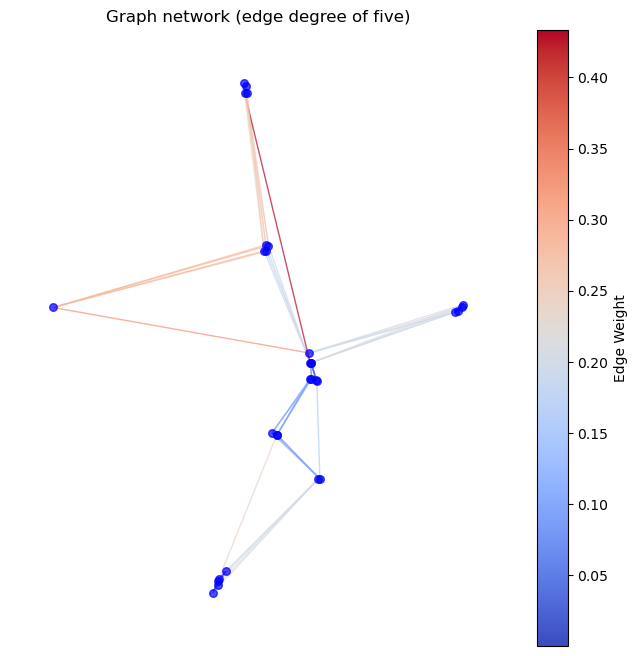

In [85]:
# Create a dictionary of node positions
pos1 = {node: (data['x'], data['y']) for node, data in distance_graph_weighted.nodes(data=True)}

# Extract edge weights
edge_weights1 = nx.get_edge_attributes(distance_graph_weighted, 'weight').values()

# Normalize edge weights for color mapping
norm = mcolors.Normalize(vmin=min(edge_weights1), vmax=max(edge_weights1))
cmap = cm.get_cmap('coolwarm')  # Choose a gradient colormap

# Get edge colors based on the weights
edge_colors = [cmap(norm(weight)) for weight in edge_weights1]

# Plot the graph
fig, ax = plt.subplots(figsize=(8, 8))
nx.draw(
    distance_graph_weighted,
    pos1,
    with_labels=False,
    node_size=30,
    node_color="blue",
    alpha=0.7,
    edge_color=edge_colors,
    edge_cmap=cmap,
    edge_vmin=min(edge_weights1),
    edge_vmax=max(edge_weights1),
    ax=ax
)

# Enable axis and set labels
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
ax.set_title("Graph network (edge degree of five)")
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)  # Ensure ticks and labels are visible

# Add a colorbar for edge weights
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, label='Edge Weight')

plt.show()


In [86]:
# Analyze the graph
graph_metrics = analyze_graph(distance_graph_weighted)

# Print the results
for key, value in graph_metrics.items():
    print(f"{key}: {value}")

num_nodes: 31
num_edges: 77
density: 0.16559139784946236
is_directed: False
average_degree: 4.967741935483871
degree_distribution: [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5]
degree_centrality: {(549360.0, 6330576.0): 0.16666666666666666, (555132.0, 6317792.0): 0.16666666666666666, (555308.0, 6318304.0): 0.16666666666666666, (555292.0, 6318128.0): 0.16666666666666666, (555588.0, 6318742.0): 0.16666666666666666, (558928.0, 6322894.0): 0.16666666666666666, (558981.0, 6322888.0): 0.16666666666666666, (555341.0, 6318418.0): 0.16666666666666666, (557255.0, 6324952.0): 0.16666666666666666, (557437.0, 6324871.0): 0.16666666666666666, (557426.0, 6324854.0): 0.16666666666666666, (558870.0, 6327287.0): 0.16666666666666666, (563949.0, 6330413.0): 0.16666666666666666, (564139.0, 6330707.0): 0.16666666666666666, (564096.0, 6330582.0): 0.16666666666666666, (558845.0, 6327312.0): 0.16666666666666666, (563847.0, 6330375.0): 0.16666666666666666, (558649

# Exploring random generated graphs

In [87]:
def connect_nodes_with_erdos_renyi(df_dict, p, seed=None):
    np.random.seed(seed)
    num_nodes = len(df_dict)
    
    # Create an empty graph
    er_graph = nx.Graph()
    
    # Add nodes with attributes
    for i, (key, df) in enumerate(df_dict.items()):
        er_graph.add_node(i, 
                          x=df['Xkoordinat'].iloc[0], 
                          y=df['Ykoordinat'].iloc[0], 
                          traffic_flow=df['traffic_flow'].values)
    
    # Add edges using the ER model
    for u in er_graph.nodes:
        for v in er_graph.nodes:
            if u < v and np.random.rand() < p:
                er_graph.add_edge(u, v, weight=np.random.rand())
    
    # Get edge weights
    edge_weights = nx.get_edge_attributes(er_graph, 'weight')
    
    return er_graph, edge_weights

In [88]:
fully_connected_graph_RANDOM_WEIGHTS, fully_connected_weights = connect_nodes_with_erdos_renyi(four_days, p=0.5 ,seed=42)

/var/folders/hx/9z5qltzd4r797gj5_f5h8qjr0000gn/T/ipykernel_1378/3243065486.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('coolwarm')  # Choose a gradient colormap


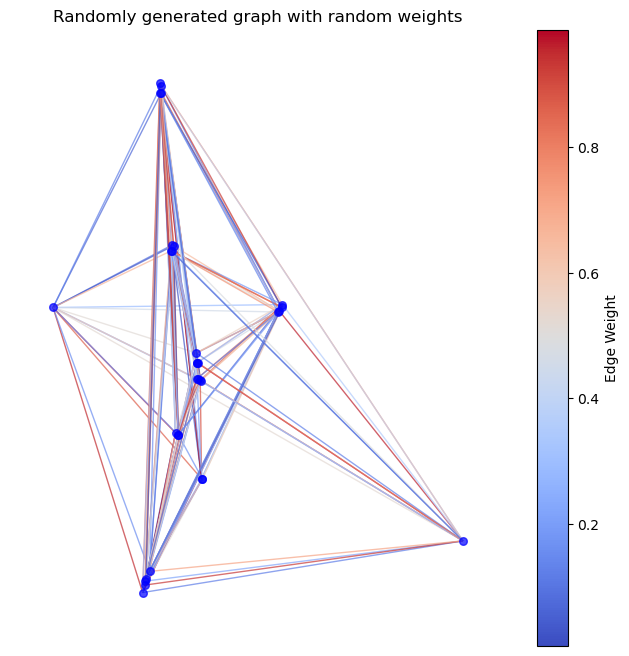

In [89]:
# Create a dictionary of node positions for the fully connected graph
pos2 = {node: (data['x'], data['y']) for node, data in fully_connected_graph_RANDOM_WEIGHTS.nodes(data=True)}

# Extract edge weights from the fully connected graph
edge_weights2 = nx.get_edge_attributes(fully_connected_graph_RANDOM_WEIGHTS, 'weight').values()

# Normalize edge weights for color mapping
norm = mcolors.Normalize(vmin=min(edge_weights2), vmax=max(edge_weights2))
cmap = cm.get_cmap('coolwarm')  # Choose a gradient colormap

# Get edge colors based on the weights
edge_colors = [cmap(norm(weight)) for weight in edge_weights2]

# Plot the graph
fig, ax = plt.subplots(figsize=(8, 8))
nx.draw(
    fully_connected_graph_RANDOM_WEIGHTS,
    pos2,
    with_labels=False,
    node_size=30,
    node_color="blue",
    alpha=0.7,
    edge_color=edge_colors,
    edge_cmap=cmap,
    edge_vmin=min(edge_weights2),
    edge_vmax=max(edge_weights2),
    ax=ax
)

# Enable axis and set labels
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
ax.set_title("Randomly generated graph with random weights")
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)  # Ensure ticks and labels are visible

# Add a colorbar for edge weights
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, label='Edge Weight')

plt.show()


/var/folders/hx/9z5qltzd4r797gj5_f5h8qjr0000gn/T/ipykernel_1378/531888372.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('coolwarm')  # Choose a gradient colormap


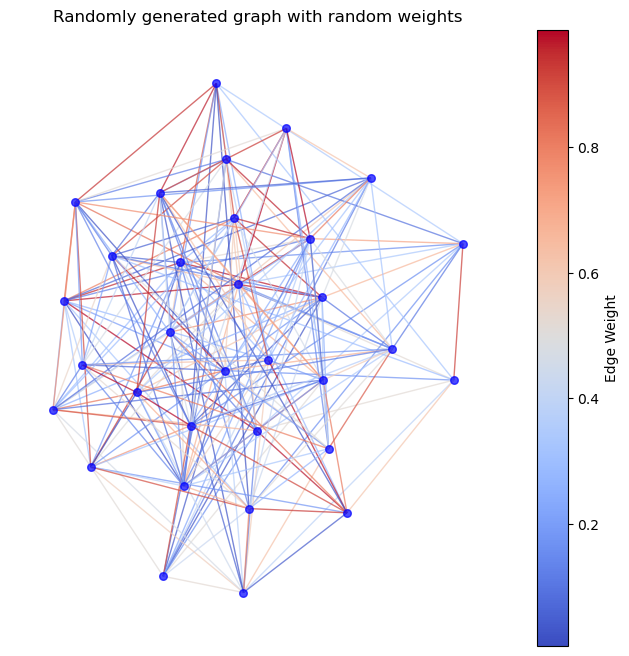

In [90]:
# Generate positions using spring layout
pos3 = nx.spring_layout(fully_connected_graph_RANDOM_WEIGHTS, seed=42)  # seed ensures reproducibility

# Extract edge weights
edge_weights3 = nx.get_edge_attributes(fully_connected_graph_RANDOM_WEIGHTS, 'weight').values()

# Normalize edge weights for color mapping
norm = mcolors.Normalize(vmin=min(edge_weights3), vmax=max(edge_weights3))
cmap = cm.get_cmap('coolwarm')  # Choose a gradient colormap

# Get edge colors based on the weights
edge_colors = [cmap(norm(weight)) for weight in edge_weights3]

# Plot the graph
fig, ax = plt.subplots(figsize=(8, 8))
nx.draw(
    fully_connected_graph_RANDOM_WEIGHTS,
    pos3,
    with_labels=False,
    node_size=30,
    node_color="blue",
    alpha=0.7,
    edge_color=edge_colors,
    edge_cmap=cmap,
    edge_vmin=min(edge_weights3),
    edge_vmax=max(edge_weights3),
    ax=ax
)

# Enable axis and set labels
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
ax.set_title("Randomly generated graph with random weights")
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)  # Ensure ticks and labels are visible

# Add a colorbar for edge weights
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, label='Edge Weight')

plt.show()


In [91]:
# Analyze the graph
graph_metrics = analyze_graph(fully_connected_graph_RANDOM_WEIGHTS)

# Print the results
for key, value in graph_metrics.items():
    print(f"{key}: {value}")

num_nodes: 32
num_edges: 227
density: 0.4576612903225806
is_directed: False
average_degree: 14.1875
degree_distribution: [17, 14, 12, 20, 11, 11, 8, 13, 16, 15, 13, 16, 12, 15, 11, 14, 14, 10, 18, 12, 16, 14, 17, 13, 14, 15, 13, 15, 14, 16, 17, 18]
degree_centrality: {0: 0.5483870967741935, 1: 0.45161290322580644, 2: 0.3870967741935484, 3: 0.6451612903225806, 4: 0.3548387096774194, 5: 0.3548387096774194, 6: 0.25806451612903225, 7: 0.4193548387096774, 8: 0.5161290322580645, 9: 0.4838709677419355, 10: 0.4193548387096774, 11: 0.5161290322580645, 12: 0.3870967741935484, 13: 0.4838709677419355, 14: 0.3548387096774194, 15: 0.45161290322580644, 16: 0.45161290322580644, 17: 0.3225806451612903, 18: 0.5806451612903225, 19: 0.3870967741935484, 20: 0.5161290322580645, 21: 0.45161290322580644, 22: 0.5483870967741935, 23: 0.4193548387096774, 24: 0.45161290322580644, 25: 0.4838709677419355, 26: 0.4193548387096774, 27: 0.4838709677419355, 28: 0.45161290322580644, 29: 0.5161290322580645, 30: 0.54838709

# Exploring correlation graphs

In [ ]:
def create_correlation_graph(df_dict_full, df_dict_train, threshold=0.5, weighted=False, degree=31):
    """
    Create a correlation graph with a maximum degree constraint using only the training data for correlations.
    """
    correlation_graph = nx.Graph()
    correlations_dict = {}

    # Add nodes to the graph using the full data
    for key, df in df_dict_full.items():
        correlation_graph.add_node(
            key,
            x=df['Xkoordinat'].iloc[0],
            y=df['Ykoordinat'].iloc[0],
            traffic_flow=df['traffic_flow'].values  # Full traffic data
        )

    # Calculate correlations using the training data
    for key1, df1_train in df_dict_train.items():
        for key2, df2_train in df_dict_train.items():
            if key1 >= key2:  # Avoid duplicate computations
                continue
            correlation = np.corrcoef(df1_train['traffic_flow'], df2_train['traffic_flow'])[0, 1]
            correlations_dict[key1, key2] = correlation
            correlations_dict[key2, key1] = correlation  # Symmetric for undirected graph

    # Add edges based on correlation, enforcing degree constraint
    for key1 in df_dict_full.keys():
        # Sort potential connections by correlation (highest first)
        potential_edges = [
            (key2, correlations_dict[key1, key2])
            for key2 in df_dict_full.keys() if key1 != key2 and (key1, key2) in correlations_dict
        ]
        potential_edges = sorted(potential_edges, key=lambda x: -x[1])  # Sort by descending correlation

        for key2, corr in potential_edges:
            if correlation_graph.degree[key1] < degree and correlation_graph.degree[key2] < degree:
                if corr > threshold:
                    if weighted:
                        correlation_graph.add_edge(key1, key2, weight=corr)
                    else:
                        correlation_graph.add_edge(key1, key2)

    # Clean graph
    correlation_graph = clean_graph(correlation_graph)
    return correlation_graph, correlations_dict

In [ ]:
correlation_graph_weighted, correlation_dict = create_correlation_graph(df_dict_full=df_dict, df_dict_train=df_dict_train, threshold=0.7, weighted=True, degree=31)
correlation_graph_unweighted, _ = create_correlation_graph(df_dict_full=df_dict, df_dict_train=df_dict_train, threshold=0.7, weighted=False, degree=31)

In [ ]:
# Create a dictionary of node positions for the fully connected graph
pos4 = {node: (data['x'], data['y']) for node, data in correlation_graph_weighted.nodes(data=True)}

# Extract edge weights from the fully connected graph
edge_weights4 = nx.get_edge_attributes(correlation_graph_weighted, 'weight').values()

# Normalize edge weights for color mapping
norm = mcolors.Normalize(vmin=min(edge_weights4), vmax=max(edge_weights4))
cmap = cm.get_cmap('coolwarm')  # Choose a gradient colormap

# Get edge colors based on the weights
edge_colors = [cmap(norm(weight)) for weight in edge_weights4]

# Plot the graph
fig, ax = plt.subplots(figsize=(8, 8))
nx.draw(
    correlation_graph_weighted,
    pos4,
    with_labels=False,
    node_size=30,
    node_color="blue",
    alpha=0.7,
    edge_color=edge_colors,
    edge_cmap=cmap,
    edge_vmin=min(edge_weights4),
    edge_vmax=max(edge_weights4),
    ax=ax
)

# Enable axis and set labels
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
ax.set_title("Correlation graph with weights")
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)  # Ensure ticks and labels are visible

# Add a colorbar for edge weights
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, label='Edge Weight')

plt.show()


In [ ]:
# Generate positions using spring layout
pos5 = nx.spring_layout(correlation_graph_weighted, seed=42)  # seed ensures reproducibility

# Extract edge weights
edge_weights5 = nx.get_edge_attributes(correlation_graph_weighted, 'weight').values()

# Normalize edge weights for color mapping
norm = mcolors.Normalize(vmin=min(edge_weights5), vmax=max(edge_weights5))
cmap = cm.get_cmap('coolwarm')  # Choose a gradient colormap

# Get edge colors based on the weights
edge_colors = [cmap(norm(weight)) for weight in edge_weights5]

# Plot the graph
fig, ax = plt.subplots(figsize=(8, 8))
nx.draw(
    correlation_graph_weighted,
    pos5,
    with_labels=False,
    node_size=30,
    node_color="blue",
    alpha=0.7,
    edge_color=edge_colors,
    edge_cmap=cmap,
    edge_vmin=min(edge_weights5),
    edge_vmax=max(edge_weights5),
    ax=ax
)

# Enable axis and set labels
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
ax.set_title("Correlation with spring layout")
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)  # Ensure ticks and labels are visible

# Add a colorbar for edge weights
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, label='Edge Weight')

plt.show()


In [ ]:
# Analyze the graph
graph_metrics = analyze_graph(correlation_graph_weighted)

# Print the results
for key, value in graph_metrics.items():
    print(f"{key}: {value}")

### Adaptive Threshold

In [ ]:
def create_adaptive_threshold_graph(df_dict_full, df_dict_train, threshold_factor=1.0, weighted=False, degree=4):
    """
    Create a graph using an adaptive threshold based on the mean and std of correlations.
    """
    graph = nx.Graph()
    correlations = {}

    # Add nodes
    for key, df in df_dict_full.items():
        graph.add_node(
            key,
            x=df['Xkoordinat'].iloc[0],
            y=df['Ykoordinat'].iloc[0],
            traffic_flow=df['traffic_flow'].values
        )

    # Compute correlations
    for key1, df1_train in df_dict_train.items():
        for key2, df2_train in df_dict_train.items():
            if key1 >= key2:
                continue
            correlation = np.corrcoef(df1_train['traffic_flow'], df2_train['traffic_flow'])[0, 1]
            correlations[key1, key2] = correlation
            correlations[key2, key1] = correlation

    # Calculate adaptive threshold
    corr_values = np.array(list(correlations.values()))
    adaptive_threshold = np.mean(corr_values) + threshold_factor * np.std(corr_values)

    # Add edges based on adaptive threshold and degree constraint
    for key1 in df_dict_full.keys():
        potential_edges = [
            (key2, correlations[key1, key2])
            for key2 in df_dict_full.keys() if key1 != key2 and (key1, key2) in correlations
        ]
        potential_edges = sorted(potential_edges, key=lambda x: -x[1])

        for key2, corr in potential_edges:
            if graph.degree[key1] < degree and graph.degree[key2] < degree:
                if corr > adaptive_threshold:
                    if weighted:
                        graph.add_edge(key1, key2, weight=corr)
                    else:
                        graph.add_edge(key1, key2)

    graph = clean_graph(graph)
    return graph, None

adaptive_graph, _ = create_adaptive_threshold_graph(final_dataframes, df_dict_train, threshold_factor=0.2, weighted=True)

In [ ]:
# Create a dictionary of node positions for the fully connected graph
pos6 = {node: (data['x'], data['y']) for node, data in adaptive_graph.nodes(data=True)}

# Extract edge weights from the fully connected graph
edge_weights6 = nx.get_edge_attributes(adaptive_graph, 'weight').values()

# Normalize edge weights for color mapping
norm = mcolors.Normalize(vmin=min(edge_weights6), vmax=max(edge_weights6))
cmap = cm.get_cmap('coolwarm')  # Choose a gradient colormap

# Get edge colors based on the weights
edge_colors = [cmap(norm(weight)) for weight in edge_weights6]

# Plot the graph
fig, ax = plt.subplots(figsize=(8, 8))
nx.draw(
    adaptive_graph,
    pos6,
    with_labels=False,
    node_size=30,
    node_color="blue",
    alpha=0.7,
    edge_color=edge_colors,
    edge_cmap=cmap,
    edge_vmin=min(edge_weights6),
    edge_vmax=max(edge_weights6),
    ax=ax
)

# Enable axis and set labels
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
ax.set_title("Adaptive threshold with weights")
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)  # Ensure ticks and labels are visible

# Add a colorbar for edge weights
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, label='Edge Weight')

plt.show()

In [ ]:
# Generate positions using spring layout
pos7 = nx.spring_layout(adaptive_graph, seed=42)  # seed ensures reproducibility

# Extract edge weights
edge_weights7 = nx.get_edge_attributes(adaptive_graph, 'weight').values()

# Normalize edge weights for color mapping
norm = mcolors.Normalize(vmin=min(edge_weights7), vmax=max(edge_weights7))
cmap = cm.get_cmap('coolwarm')  # Choose a gradient colormap

# Get edge colors based on the weights
edge_colors = [cmap(norm(weight)) for weight in edge_weights7]

# Plot the graph
fig, ax = plt.subplots(figsize=(8, 8))
nx.draw(
    adaptive_graph,
    pos7,
    with_labels=False,
    node_size=30,
    node_color="blue",
    alpha=0.7,
    edge_color=edge_colors,
    edge_cmap=cmap,
    edge_vmin=min(edge_weights7),
    edge_vmax=max(edge_weights7),
    ax=ax
)

# Enable axis and set labels
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
ax.set_title("Adaptive threshold with spring layout")
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)  # Ensure ticks and labels are visible

# Add a colorbar for edge weights
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, label='Edge Weight')

plt.show()

In [ ]:
# Analyze the graph
graph_metrics = analyze_graph(adaptive_graph)

# Print the results
for key, value in graph_metrics.items():
    print(f"{key}: {value}")

### Delaunay graph

In [ ]:
def create_delaunay_graph(df_dict):
    """
    Create a Delaunay triangulation graph based on spatial coordinates.
    """
    graph = nx.Graph()
    points = []
    node_mapping = {}

    # Collect node coordinates
    for i, (key, df) in enumerate(df_dict.items()):
        points.append((df['Xkoordinat'].iloc[0], df['Ykoordinat'].iloc[0]))
        node_mapping[i] = key
        graph.add_node(key, x=df['Xkoordinat'].iloc[0], y=df['Ykoordinat'].iloc[0])

    # Perform Delaunay triangulation
    tri = Delaunay(points)
    # Plot traingularization

    # Add edges from triangulation
    for simplex in tri.simplices:
        for i in range(3):
            u, v = node_mapping[simplex[i]], node_mapping[simplex[(i + 1) % 3]]
            graph.add_edge(u, v)

    return clean_graph(graph),  None

delaunay_graph, _ = create_delaunay_graph(df_dict)

In [ ]:
# Create a dictionary of node positions for the fully connected graph
pos8 = {node: (data['x'], data['y']) for node, data in delaunay_graph.nodes(data=True)}

# Plot the graph
fig, ax = plt.subplots(figsize=(8, 8))
nx.draw(
    delaunay_graph,
    pos8,
    with_labels=False,
    node_size=30,
    node_color="blue",
    alpha=0.7,
    edge_color="black",
    ax=ax
)

# Enable axis and set labels
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
ax.set_title("Delaunay graph without weights")
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)  # Ensure ticks and labels are visible

plt.show()


# Create a dictionary of node positions for the fully connected graph
pos8 = {node: (data['x'], data['y']) for node, data in delaunay_graph.nodes(data=True)}

# Extract edge weights from the fully connected graph
edge_weights8 = nx.get_edge_attributes(delaunay_graph, 'weight').values()

# Normalize edge weights for color mapping
norm = mcolors.Normalize(vmin=min(edge_weights8), vmax=max(edge_weights8))
cmap = cm.get_cmap('coolwarm')  # Choose a gradient colormap

# Get edge colors based on the weights
edge_colors = [cmap(norm(weight)) for weight in edge_weights8]

# Plot the graph
fig, ax = plt.subplots(figsize=(8, 8))
nx.draw(
    delaunay_graph,
    pos8,
    with_labels=False,
    node_size=30,
    node_color="blue",
    alpha=0.7,
    edge_color=edge_colors,
    edge_cmap=cmap,
    edge_vmin=min(edge_weights8),
    edge_vmax=max(edge_weights8),
    ax=ax
)

# Enable axis and set labels
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
ax.set_title("delaunay_graph with weights")
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)  # Ensure ticks and labels are visible

# Add a colorbar for edge weights
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, label='Edge Weight')

plt.show()


# Generate positions using spring layout
pos9 = nx.spring_layout(delaunay_graph, seed=42)  # seed ensures reproducibility

# Extract edge weights
edge_weights9 = nx.get_edge_attributes(delaunay_graph, 'weight').values()

# Normalize edge weights for color mapping
norm = mcolors.Normalize(vmin=min(edge_weights9), vmax=max(edge_weights9))
cmap = cm.get_cmap('coolwarm')  # Choose a gradient colormap

# Get edge colors based on the weights
edge_colors = [cmap(norm(weight)) for weight in edge_weights9]

# Plot the graph
fig, ax = plt.subplots(figsize=(8, 8))
nx.draw(
    delaunay_graph,
    pos9,
    with_labels=False,
    node_size=30,
    node_color="blue",
    alpha=0.7,
    edge_color=edge_colors,
    edge_cmap=cmap,
    edge_vmin=min(edge_weights9),
    edge_vmax=max(edge_weights9),
    ax=ax
)

# Enable axis and set labels
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
ax.set_title("delaunay_graph graph with spring layout")
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)  # Ensure ticks and labels are visible

# Add a colorbar for edge weights
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, label='Edge Weight')

plt.show()


In [ ]:
# Analyze the graph
graph_metrics = analyze_graph(delaunay_graph)

# Print the results
for key, value in graph_metrics.items():
    print(f"{key}: {value}")

### Consine Similarity

In [ ]:
def create_cosine_similarity_graph(df_dict, weighted=False, degree=4):
    """
    Create a graph based on cosine similarity between node features.
    """
    graph = nx.Graph()
    feature_vectors = {}
    similarities = {}

    # Add nodes and collect feature vectors
    for key, df in df_dict.items():
        graph.add_node(
            key,
            x=df['Xkoordinat'].iloc[0],
            y=df['Ykoordinat'].iloc[0],
            traffic_flow=df['traffic_flow'].values
        )
        feature_vectors[key] = df['traffic_flow'].values

    # Compute cosine similarities
    keys = list(feature_vectors.keys())
    vectors = np.array([feature_vectors[key] for key in keys])
    similarity_matrix = cosine_similarity(vectors)

    for i, key1 in enumerate(keys):
        for j, key2 in enumerate(keys):
            if i >= j:
                continue
            similarities[key1, key2] = similarity_matrix[i, j]
            similarities[key2, key1] = similarity_matrix[i, j]

    # Add edges based on similarity and degree constraint
    for key1 in df_dict.keys():
        potential_edges = [
            (key2, similarities[key1, key2])
            for key2 in df_dict.keys() if key1 != key2 and (key1, key2) in similarities
        ]
        potential_edges = sorted(potential_edges, key=lambda x: -x[1])

        for key2, sim in potential_edges:
            if graph.degree[key1] < degree and graph.degree[key2] < degree:
                if weighted:
                    graph.add_edge(key1, key2, weight=sim)
                else:
                    graph.add_edge(key1, key2)

    graph = clean_graph(graph)
    return graph, None

cosine_graph, _ = create_cosine_similarity_graph(df_dict_train, weighted=True)

In [ ]:
# Create a dictionary of node positions for the fully connected graph
pos10 = {node: (data['x'], data['y']) for node, data in cosine_graph.nodes(data=True)}

# Extract edge weights from the fully connected graph
edge_weights10 = nx.get_edge_attributes(cosine_graph, 'weight').values()

# Normalize edge weights for color mapping
norm = mcolors.Normalize(vmin=min(edge_weights10), vmax=max(edge_weights10))
cmap = cm.get_cmap('coolwarm')  # Choose a gradient colormap

# Get edge colors based on the weights
edge_colors = [cmap(norm(weight)) for weight in edge_weights10]

# Plot the graph
fig, ax = plt.subplots(figsize=(8, 8))
nx.draw(
    cosine_graph,
    pos10,
    with_labels=False,
    node_size=30,
    node_color="blue",
    alpha=0.7,
    edge_color=edge_colors,
    edge_cmap=cmap,
    edge_vmin=min(edge_weights10),
    edge_vmax=max(edge_weights10),
    ax=ax
)

# Enable axis and set labels
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
ax.set_title("Graph based on Cosine Similarity")
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)  # Ensure ticks and labels are visible

# Add a colorbar for edge weights
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, label='Edge Weight')

plt.show()


In [ ]:
# Generate positions using spring layout
pos11 = nx.spring_layout(cosine_graph, seed=42)  # seed ensures reproducibility

# Extract edge weights
edge_weights11 = nx.get_edge_attributes(cosine_graph, 'weight').values()

# Normalize edge weights for color mapping
norm = mcolors.Normalize(vmin=min(edge_weights11), vmax=max(edge_weights11))
cmap = cm.get_cmap('coolwarm')  # Choose a gradient colormap

# Get edge colors based on the weights
edge_colors = [cmap(norm(weight)) for weight in edge_weights11]

# Plot the graph
fig, ax = plt.subplots(figsize=(8, 8))
nx.draw(
    cosine_graph,
    pos11,
    with_labels=False,
    node_size=30,
    node_color="blue",
    alpha=0.7,
    edge_color=edge_colors,
    edge_cmap=cmap,
    edge_vmin=min(edge_weights11),
    edge_vmax=max(edge_weights11),
    ax=ax
)

# Enable axis and set labels
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
ax.set_title("cosine_graph with spring layout")
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)  # Ensure ticks and labels are visible

# Add a colorbar for edge weights
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, label='Edge Weight')

plt.show()


In [ ]:
# Analyze the graph
graph_metrics = analyze_graph(cosine_graph)

# Print the results
for key, value in graph_metrics.items():
    print(f"{key}: {value}")

### Exploring auto encoded feature graphs

In [29]:
import numpy as np
import networkx as nx
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau

def process_and_create_correlation_graph(df_dict_full, df_dict_train, threshold=0.5, encoding_dim=50, epochs=100, batch_size=128):
    def autoencode_column(data, encoding_dim, epochs, batch_size):
        """Autoencode the column data."""
        data = np.array(data).reshape(-1, 1)  # Ensure proper shape
        input_dim = data.shape[1]
        
        # Normalize data
        scaler = MinMaxScaler()
        data = scaler.fit_transform(data)

        def build_autoencoder(input_dim, encoding_dim):
            input_layer = Input(shape=(input_dim,))
            encoded = Dense(128, activation='relu')(input_layer)
            encoded = Dense(64, activation='relu')(encoded)
            encoded = Dropout(0.2)(encoded)  # Prevent overfitting
            encoded = Dense(encoding_dim, activation='relu')(encoded)
            decoded = Dense(64, activation='relu')(encoded)
            decoded = Dense(128, activation='relu')(decoded)
            decoded = Dense(input_dim, activation='sigmoid')(decoded)  # Use 'linear' for normalized input
            autoencoder = Model(inputs=input_layer, outputs=decoded)
            return autoencoder, input_layer, encoded

        autoencoder, input_layer, encoded = build_autoencoder(input_dim, encoding_dim)

        # Learning rate scheduler
        lr_scheduler = ReduceLROnPlateau(
            monitor='loss', 
            factor=0.5, 
            patience=3, 
            min_lr=1e-6, 
            verbose=0
        )
        
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='loss', 
            patience=20, 
            restore_best_weights=True, 
            verbose=0
        )
        
        # Compile and train autoencoder
        autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')
        autoencoder.fit(
            data, data, 
            epochs=epochs, 
            batch_size=min(batch_size, len(data)), 
            shuffle=True, 
            verbose=1, 
            callbacks=[lr_scheduler, early_stopping]
        )
        
        # Extract encoded data
        encoder = Model(inputs=input_layer, outputs=encoded)
        encoded_data = encoder.predict(data)
        return encoded_data  # Return as 2D array

    # Process traffic flow data in both dictionaries
    for df_dict in [df_dict_full, df_dict_train]:
        for key, df in df_dict.items():
            if 'traffic_flow' in df.columns:
                df['traffic_flow_encoded'] = list(autoencode_column(df['traffic_flow'].values, encoding_dim, epochs, batch_size))

    # Create correlation graph
    correlation_graph = nx.Graph()
    keys = list(df_dict_full.keys())

    # Add nodes
    for key, df in df_dict_full.items():
        correlation_graph.add_node(
            key,
            x=df['Xkoordinat'].iloc[0],
            y=df['Ykoordinat'].iloc[0],
            traffic_flow_encoded=df['traffic_flow_encoded'],
        )

    # Precompute pairwise correlations
    encoded_data_matrix = []
    for key in keys:
        encoded_data = np.array(df_dict_full[key]['traffic_flow_encoded'].tolist())  # Ensure it's a 2D array
        encoded_data_matrix.append(encoded_data)

    # Stack all encoded data into a single matrix
    encoded_data_matrix = np.vstack(encoded_data_matrix)  # Combine all rows into one matrix

    # Check the shape of the resulting matrix
    print(f"Encoded data matrix shape: {encoded_data_matrix.shape}")

    # Compute correlation matrix
    correlation_matrix = np.corrcoef(encoded_data_matrix, rowvar=False)

    # Add edges
    for i, key1 in enumerate(keys):
        for j, key2 in enumerate(keys):
            if i >= j:
                continue
            similarity = correlation_matrix[i, j]
            if np.isnan(similarity) or similarity <= threshold:
                continue
            correlation_graph.add_edge(key1, key2, weight=similarity)
    
    return correlation_graph


In [30]:
def autoencode_column(data, encoding_dim, epochs, batch_size):
    """Autoencode the column data and calculate reconstruction accuracy."""
    data = np.array(data).reshape(-1, 1)  # Ensure proper shape
    input_dim = data.shape[1]
    
    # Normalize data
    scaler = MinMaxScaler()
    data = scaler.fit_transform(data)

    def build_autoencoder(input_dim, encoding_dim):
        input_layer = Input(shape=(input_dim,))
        encoded = Dense(128, activation='relu')(input_layer)
        encoded = Dense(64, activation='relu')(encoded)
        encoded = Dropout(0.2)(encoded)  # Prevent overfitting
        encoded = Dense(encoding_dim, activation='relu')(encoded)
        decoded = Dense(64, activation='relu')(encoded)
        decoded = Dense(128, activation='relu')(decoded)
        decoded = Dense(input_dim, activation='sigmoid')(decoded)  # Use 'linear' for normalized input
        autoencoder = Model(inputs=input_layer, outputs=decoded)
        return autoencoder, input_layer, encoded, decoded

    autoencoder, input_layer, encoded, decoded = build_autoencoder(input_dim, encoding_dim)

    # Learning rate scheduler
    lr_scheduler = ReduceLROnPlateau(
        monitor='loss', 
        factor=0.5, 
        patience=3, 
        min_lr=1e-6, 
        verbose=0
    )
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='loss', 
        patience=20, 
        restore_best_weights=True, 
        verbose=0
    )
    
    # Compile and train autoencoder
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')
    history = autoencoder.fit(
        data, data, 
        epochs=epochs, 
        batch_size=min(batch_size, len(data)), 
        shuffle=True, 
        verbose=1, 
        callbacks=[lr_scheduler, early_stopping]
    )
    
    # Calculate reconstruction accuracy
    reconstructed_data = autoencoder.predict(data)
    reconstruction_loss = np.mean(np.square(data - reconstructed_data))
    print(f"Average reconstruction MSE: {reconstruction_loss:.6f}")
    
    # Extract encoded data
    encoder = Model(inputs=input_layer, outputs=encoded)
    encoded_data = encoder.predict(data)
    
    return encoded_data, reconstruction_loss  # Return as 2D array


In [33]:
def process_and_create_correlation_graph(df_dict_full, df_dict_train, encoding_dim=50, epochs=100, batch_size=128):
     # Process traffic flow data in both dictionaries
    for df_dict in [df_dict_full, df_dict_train]:
        for key, df in df_dict.items():
            if 'traffic_flow' in df.columns:
                df['traffic_flow_encoded'], df['reconstruction_loss']  = list(autoencode_column(df['traffic_flow'].values, encoding_dim, epochs, batch_size))

    return df_dict_full

df_dict_full = process_and_create_correlation_graph(final_dataframes, df_dict_train, encoding_dim=100, epochs=100, batch_size=512)

Epoch 1/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0261 - learning_rate: 0.0100
Epoch 2/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8668e-04 - learning_rate: 0.0100
Epoch 3/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2120e-04 - learning_rate: 0.0100
Epoch 4/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3632e-04 - learning_rate: 0.0100
Epoch 5/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.0765e-05 - learning_rate: 0.0100
Epoch 6/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.2491e-05 - learning_rate: 0.0100
Epoch 7/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.7166e-05 - learning_rate: 0.0100
Epoch 8/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.0550e-05 - learning_rate: 0.0100
Epoch 9/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9768e-05 - learning_rate: 0.0050
Epoch 10/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8999e-05 - learning_rate: 0.0050
Epoch 11/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.6

In [34]:
for key, df in df_dict.items():
    avg_reconstruction_loss = df['reconstruction_loss'].mean()
    print(f"Average reconstruction loss for dataframe with key {key}: {avg_reconstruction_loss}")

Average reconstruction loss for dataframe with key (549360.0, 6330576.0): 0.002532977796018513
Average reconstruction loss for dataframe with key (555132.0, 6317792.0): 0.003082851004308267
Average reconstruction loss for dataframe with key (555308.0, 6318304.0): 0.002576605501884023
Average reconstruction loss for dataframe with key (555292.0, 6318128.0): 0.0014356711351936923
Average reconstruction loss for dataframe with key (555588.0, 6318742.0): 0.0025112102822481717
Average reconstruction loss for dataframe with key (558928.0, 6322894.0): 0.0007612406018629026
Average reconstruction loss for dataframe with key (558981.0, 6322888.0): 0.001737325863511806
Average reconstruction loss for dataframe with key (555341.0, 6318418.0): 0.0012692186163201428
Average reconstruction loss for dataframe with key (557255.0, 6324952.0): 0.0013259599498150793
Average reconstruction loss for dataframe with key (557437.0, 6324871.0): 0.0013864828977139876
Average reconstruction loss for dataframe wi

In [ ]:
# Create correlation graph
encoded_graph = nx.Graph()
keys = list(df_dict_full.keys())

# Add nodes
for key, df in df_dict_full.items():
    encoded_graph.add_node(
        key,
        x=df['Xkoordinat'].iloc[0],
        y=df['Ykoordinat'].iloc[0],
        traffic_flow_encoded=df['traffic_flow_encoded'],
    )

# Precompute pairwise correlations
encoded_data_matrix = []
for key in keys:
    encoded_data = np.array(df_dict_full[key]['traffic_flow_encoded'].tolist())  # Ensure it's a 2D array
    encoded_data_matrix.append(encoded_data)

# Stack all encoded data into a single matrix
encoded_data_matrix = np.vstack(encoded_data_matrix)  # Combine all rows into one matrix

# Check the shape of the resulting matrix
print(f"Encoded data matrix shape: {encoded_data_matrix.shape}")

# Compute correlation matrix
correlation_matrix = np.corrcoef(encoded_data_matrix, rowvar=False)

# Add edges
for i, key1 in enumerate(keys):
    for j, key2 in enumerate(keys):
        if i >= j:
            continue
        similarity = correlation_matrix[i, j]
        if np.isnan(similarity) or similarity <= 0.5:
            continue
        encoded_graph.add_edge(key1, key2, weight=similarity)
    



In [ ]:
#encoded_graph = process_and_create_correlation_graph(final_dataframes, df_dict_train, threshold=0.5, encoding_dim=100, epochs=100, batch_size=512)

Epoch 1/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0230 - learning_rate: 0.0100
Epoch 2/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6340e-04 - learning_rate: 0.0100
Epoch 3/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6754e-04 - learning_rate: 0.0100
Epoch 4/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.3590e-05 - learning_rate: 0.0100
Epoch 5/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5472e-04 - learning_rate: 0.0100
Epoch 6/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.6774e-05 - learning_rate: 0.0100
Epoch 7/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.7349e-05 - learning_rate: 0.0100
Epoch 8/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.8144e-05 - learning_rate: 0.0100
Epoch 9/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.7747e-05 - learning_rate: 0.0100
Epoch 10/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8522e-05 - learning_rate: 0.0050
Epoch 11/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8

KeyboardInterrupt: 

In [ ]:
rec_loss

In [ ]:
print("Min weight:", min(edge_weights))
print("Max weight:", max(edge_weights))
print("Weights:", list(edge_weights))


/var/folders/hx/9z5qltzd4r797gj5_f5h8qjr0000gn/T/ipykernel_1378/2229680602.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('coolwarm')  # Choose a gradient colormap


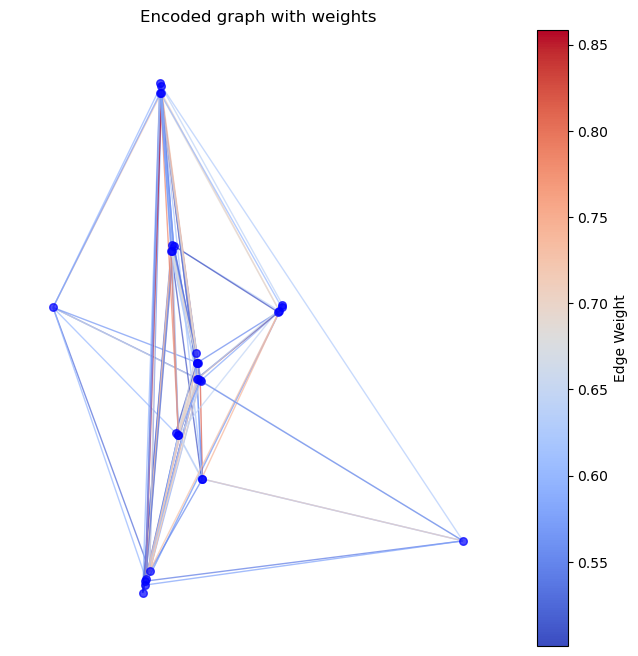

In [11]:
# Create a dictionary of node positions for the fully connected graph
pos7 = {node: (data['x'], data['y']) for node, data in encoded_graph.nodes(data=True)}

# Extract edge weights from the fully connected graph
edge_weights = nx.get_edge_attributes(encoded_graph, 'weight').values()

# Normalize edge weights for color mapping
norm = mcolors.Normalize(vmin=min(edge_weights), vmax=max(edge_weights))
cmap = cm.get_cmap('coolwarm')  # Choose a gradient colormap

# Get edge colors based on the weights
edge_colors = [cmap(norm(weight)) for weight in edge_weights]

# Plot the graph
fig, ax = plt.subplots(figsize=(8, 8))
nx.draw(
    encoded_graph,
    pos7,
    with_labels=False,
    node_size=30,
    node_color="blue",
    alpha=0.7,
    edge_color=edge_colors,
    edge_cmap=cmap,
    edge_vmin=min(edge_weights),
    edge_vmax=max(edge_weights),
    ax=ax
)

# Enable axis and set labels
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
ax.set_title("Encoded graph with weights")
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)  # Ensure ticks and labels are visible

# Add a colorbar for edge weights
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, label='Edge Weight')

plt.show()


In [14]:
# Analyze the graph
graph_metrics = analyze_graph(encoded_graph)

# Print the results
for key, value in graph_metrics.items():
    print(f"{key}: {value}")

num_nodes: 32
num_edges: 133
density: 0.26814516129032256
is_directed: False
average_degree: 8.3125
degree_distribution: [9, 7, 3, 12, 9, 5, 6, 8, 4, 6, 12, 10, 10, 4, 4, 9, 2, 2, 10, 17, 18, 11, 9, 1, 10, 6, 13, 5, 9, 15, 13, 7]
degree_centrality: {(549360.0, 6330576.0): 0.29032258064516125, (555132.0, 6317792.0): 0.22580645161290322, (555308.0, 6318304.0): 0.0967741935483871, (555292.0, 6318128.0): 0.3870967741935484, (555588.0, 6318742.0): 0.29032258064516125, (558928.0, 6322894.0): 0.16129032258064516, (558981.0, 6322888.0): 0.1935483870967742, (555341.0, 6318418.0): 0.25806451612903225, (557255.0, 6324952.0): 0.12903225806451613, (557437.0, 6324871.0): 0.1935483870967742, (557426.0, 6324854.0): 0.3870967741935484, (558870.0, 6327287.0): 0.3225806451612903, (563949.0, 6330413.0): 0.3225806451612903, (564139.0, 6330707.0): 0.12903225806451613, (564096.0, 6330582.0): 0.12903225806451613, (558845.0, 6327312.0): 0.29032258064516125, (563847.0, 6330375.0): 0.06451612903225806, (558649.0

### V2

In [ ]:
def process_and_create_correlation_graph_v2(df_dict_full, df_dict_train, threshold=0.5, encoding_dim=50, epochs=100, batch_size=128):
    def autoencode_combined_data(combined_data, encoding_dim, epochs, batch_size):
        """Train a single autoencoder on combined traffic flow data."""
        combined_data = [x for x in combined_data if not np.isnan(x)]  # Remove NaNs
        combined_data = np.array(combined_data).reshape(-1, 1) if not isinstance(combined_data, np.ndarray) else combined_data.reshape(-1, 1)  # Ensure proper shape
        input_dim = combined_data.shape[1]

        # Normalize data
        scaler = MinMaxScaler()
        combined_data = scaler.fit_transform(combined_data)

        def build_autoencoder(input_dim, encoding_dim):
            input_layer = Input(shape=(input_dim,))
            encoded = Dense(128, activation='relu')(input_layer)
            encoded = Dense(64, activation='relu')(encoded)
            encoded = Dropout(0.2)(encoded)  # Prevent overfitting
            encoded = Dense(encoding_dim, activation='relu')(encoded)
            decoded = Dense(64, activation='relu')(encoded)
            decoded = Dense(128, activation='relu')(decoded)
            decoded = Dense(input_dim, activation='sigmoid')(decoded)  # Use 'linear' for normalized input
            autoencoder = Model(inputs=input_layer, outputs=decoded)
            return autoencoder, input_layer, encoded

        autoencoder, input_layer, encoded = build_autoencoder(input_dim, encoding_dim)

        # Learning rate scheduler
        lr_scheduler = ReduceLROnPlateau(
            monitor='loss', 
            factor=0.5, 
            patience=3, 
            min_lr=1e-6, 
            verbose=0
        )

        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='loss', 
            patience=5, 
            restore_best_weights=True, 
            verbose=0
        )

        # Compile and train autoencoder
        autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')
        autoencoder.fit(
            combined_data, combined_data,
            epochs=epochs,
            batch_size=min(batch_size, len(combined_data)),
            shuffle=True,
            verbose=1,
            callbacks=[lr_scheduler, early_stopping]
        )

        # Extract encoded data
        encoder = Model(inputs=input_layer, outputs=encoded)
        encoded_data = encoder.predict(combined_data)
        return autoencoder, encoder, scaler

    # Combine traffic flow data from all DataFrames
    all_traffic_flow_data = []
    for df_dict in [df_dict_full, df_dict_train]:
        for key, df in df_dict.items():
            if 'traffic_flow' in df.columns:
                all_traffic_flow_data.extend(df['traffic_flow'].values)

    # Train single autoencoder on combined traffic flow data
    autoencoder, encoder, scaler = autoencode_combined_data(all_traffic_flow_data, encoding_dim, epochs, batch_size)

    # Encode traffic flow data for each DataFrame
    for df_dict in [df_dict_full, df_dict_train]:
        for key, df in df_dict.items():
            if 'traffic_flow' in df.columns:
                traffic_flow_values = df['traffic_flow'].values
                traffic_flow_values = [x for x in traffic_flow_values if not np.isnan(x)]  # Remove NaNs
                if not isinstance(traffic_flow_values, np.ndarray):
                    traffic_flow_values = np.array(traffic_flow_values).reshape(-1, 1)
                else:
                    traffic_flow_values = traffic_flow_values.reshape(-1, 1)
                normalized_data = scaler.transform(traffic_flow_values)
                encoded_data = encoder.predict(normalized_data)
                df['traffic_flow_encoded'] = list(encoded_data)

    # Create correlation graph
    correlation_graph = nx.Graph()
    keys = list(df_dict_full.keys())

    # Add nodes
    for key, df in df_dict_full.items():
        correlation_graph.add_node(
            key,
            x=df['Xkoordinat'].iloc[0],
            y=df['Ykoordinat'].iloc[0],
            traffic_flow_encoded=df['traffic_flow_encoded'],
        )

    # Collect encoded data into a matrix
    encoded_data_matrix = []
    for key in keys:
        encoded_data = np.array(df_dict_full[key]['traffic_flow_encoded'])  # Already encoded
        # Ensure consistent shape
        if encoded_data.ndim == 1:
            encoded_data = encoded_data.reshape(-1, 1)  # Make 2D
        encoded_data_matrix.append(encoded_data)

    # Stack all encoded data vertically
    encoded_data_matrix = np.vstack(encoded_data_matrix)

    # Verify shape
    print("Encoded Data Matrix Shape:", encoded_data_matrix.shape)

    # Compute correlation matrix
    correlation_matrix = np.corrcoef(encoded_data_matrix, rowvar=False)
    print("Correlation Matrix Shape:", correlation_matrix.shape)

    # Add edges
    for i, key1 in enumerate(keys):
        for j, key2 in enumerate(keys):
            if i >= j:
                continue
            similarity = correlation_matrix[i, j]
            if np.isnan(similarity) or similarity <= threshold:
                continue
            correlation_graph.add_edge(key1, key2, weight=similarity)
    
    return correlation_graph

encoded_graph_v2 = process_and_create_correlation_graph_v2(final_dataframes, df_dict_train, threshold=0.5, encoding_dim=100, epochs=100, batch_size=512)

In [ ]:
print("Min weight:", min(edge_weights))
print("Max weight:", max(edge_weights))
print("Weights:", list(edge_weights))

In [ ]:
# Create a dictionary of node positions for the fully connected graph
pos8 = {node: (data['x'], data['y']) for node, data in encoded_graph_v2.nodes(data=True)}

# Extract edge weights from the fully connected graph
edge_weights = nx.get_edge_attributes(encoded_graph_v2, 'weight').values()

# Normalize edge weights for color mapping
norm = mcolors.Normalize(vmin=min(edge_weights), vmax=max(edge_weights))
cmap = cm.get_cmap('coolwarm')  # Choose a gradient colormap

# Get edge colors based on the weights
edge_colors = [cmap(norm(weight)) for weight in edge_weights]

# Plot the graph
fig, ax = plt.subplots(figsize=(8, 8))
nx.draw(
    encoded_graph_v2,
    pos8,
    with_labels=False,
    node_size=30,
    node_color="blue",
    alpha=0.7,
    edge_color=edge_colors,
    edge_cmap=cmap,
    edge_vmin=min(edge_weights),
    edge_vmax=max(edge_weights),
    ax=ax
)

# Enable axis and set labels
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
ax.set_title("Encoded graph V2 with weights")
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)  # Ensure ticks and labels are visible

# Add a colorbar for edge weights
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, label='Edge Weight')

plt.show()
